# pyWavelet Snow Radar Processor

In [1]:
#pyWavelet modules
from pyWavelet import snowradar, picklayers

#Python stdlib
import os
import datetime
import time

#Community packages
import numpy as np
import matplotlib.pyplot as plt

In [2]:
density_snow = 0.300 #Density of snow on sea ice; See Alexandrov et al., 2010, The Cryosphere
perm_snow = (1 + 0.51 * density_snow) ** 3  #Density to permitivity
n_snow = np.sqrt(perm_snow) #Permitivity to refractive index
c = 299792458 #Vacuum speed of light

In [3]:
#radar_file = "./data/sr/Data_20160419_04_010.mat"
#radar_file = "./data/eureka/sr/Data_20160419_04_025.mat"
#radar_file = "./data/sr/Data_20160420_02_090.mat"
#radar_file = "E:/OIB/snowradar/CSARP_deconv/20170310_01/Data_20170310_01_088.mat"
#radar_file = "E:/OIB/snowradar/CSARP_deconv/Data_20160419_05_005.mat"
#radar_file = "./data/sr/Data_20160420_02_090.mat"
radar_file = "./data/awi/Data_20170410_01_006.mat"


radar_dat = snowradar.SnowRadar(radar_file, l_case='full')

Processing: C:\Users\Mikeb\Documents\GitHub\pyWavelet\pyWavelet\data\awi\Data_20170410_01_006.mat


Convert the radar's GPS time to UTC and account for leap seconds

In [4]:
example_date = datetime.datetime.utcfromtimestamp(radar_dat.time_utc[0])
print(example_date)

2017-04-10 23:33:18.698044


In [5]:
#radar_dat.decompress_data()
radar_sub = radar_dat.data_radar

#radar_sub = radar_dat.data_radar*5e10
#radar_sub = radar_dat.data_radar #*50000000000


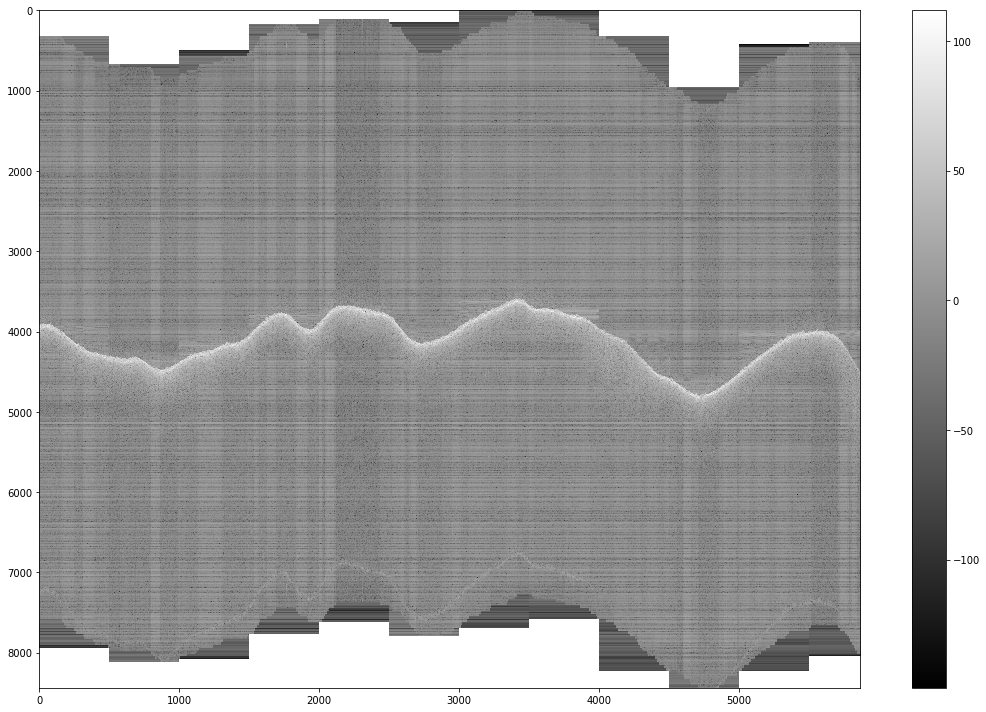

In [6]:
fig, ax = plt.subplots(figsize=(15,10))
with np.errstate(divide='ignore'):
    im = ax.imshow(20 * np.log10(radar_sub), cmap="gist_gray")
ax.set_aspect('auto')
fig.colorbar(im, ax=ax)
fig.tight_layout();

### Signals stuff

In [7]:
oversample_num = 1000
num_nyquist_ts = 100
nyquist_sf = 2*radar_dat.bandwidth
fs = nyquist_sf *oversample_num 
time_step = 1/fs 
max_time  = num_nyquist_ts*oversample_num*time_step
time_vect = np.arange(-max_time,max_time,time_step)

In [8]:
radar_dat.calcpulsewidth()
print(radar_dat.epw)
print(radar_dat.n2n)

0.028389437310606058
0.075697595645


### This applies the picklayer function to every trace
TODO: Multi thread and bake into snowradar class

In [10]:
with np.errstate(invalid='ignore', divide='ignore'):
    l_as, l_si = np.apply_along_axis(
        picklayers.picklayers, 
        0, 
        radar_sub,
        radar_dat.n2n,
        radar_dat.dfr,
        n_snow
    )

In [11]:
snow_depth = (l_si - l_as) * radar_dat.dfr / n_snow

# Retrieval output

Max along-track resolution
Mean depth (m): 30.136045430417447
StDev of  depth (m): 2.334486402674046

5-bin averaged along-track 
Mean snow depth (m): 30.135414462623032
StDev of snow depth (m): 2.3331877256440827


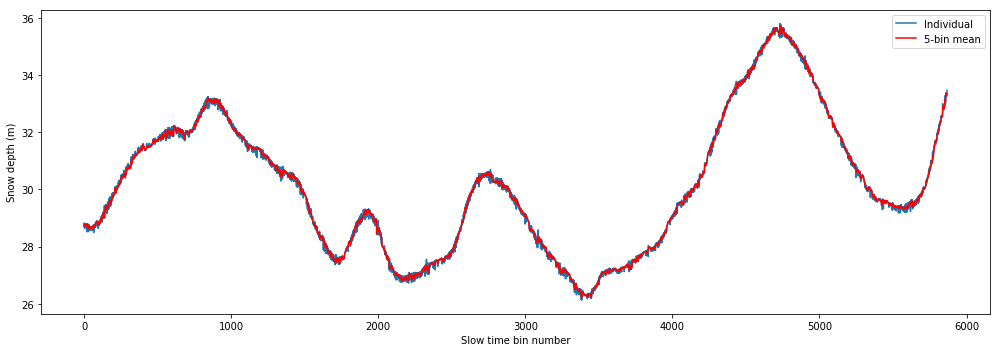

In [12]:
N = 5
snow_depth_rollin = np.convolve(snow_depth, np.ones((N,))/N, mode='valid')
estart = N/2
eend = len(snow_depth_rollin)+(N/2)
print("Max along-track resolution")
print("Mean depth (m):", np.mean(snow_depth))
print("StDev of  depth (m):", np.std(snow_depth))
print("\n5-bin averaged along-track ")
print("Mean snow depth (m):", np.mean(snow_depth_rollin))
print("StDev of snow depth (m):", np.std(snow_depth_rollin))

fig, ax = plt.subplots(figsize=(14,5))
ax.plot(snow_depth)
#ax.plot(np.arange(0, len(snow_depth_rollin)),snow_depth_rollin, color='r')
ax.plot(np.arange(estart, eend),snow_depth_rollin, color='r')

#ax.plot(l_as, color='b')
ax.set_ylabel("Snow depth (m)")
ax.set_xlabel("Slow time bin number")
ax.legend(["Individual","5-bin mean"],loc="upper right")
fig.tight_layout();

#fig.savefig('20170310_01_088_Depth.pdf')

(array([136., 164., 471., 405., 290., 212., 293., 275., 443., 333., 334.,
        375., 184., 298., 264., 338., 150., 157., 165., 106.,  81.,  78.,
         78., 102., 132.]),
 array([26.21502782, 26.59471312, 26.97439843, 27.35408374, 27.73376904,
        28.11345435, 28.49313966, 28.87282496, 29.25251027, 29.63219558,
        30.01188089, 30.39156619, 30.7712515 , 31.15093681, 31.53062211,
        31.91030742, 32.28999273, 32.66967803, 33.04936334, 33.42904865,
        33.80873395, 34.18841926, 34.56810457, 34.94778988, 35.32747518,
        35.70716049]),
 <a list of 25 Patch objects>)

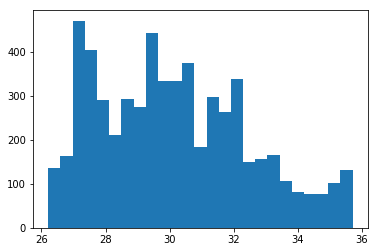

In [13]:
plt.hist(snow_depth_rollin, bins=25)

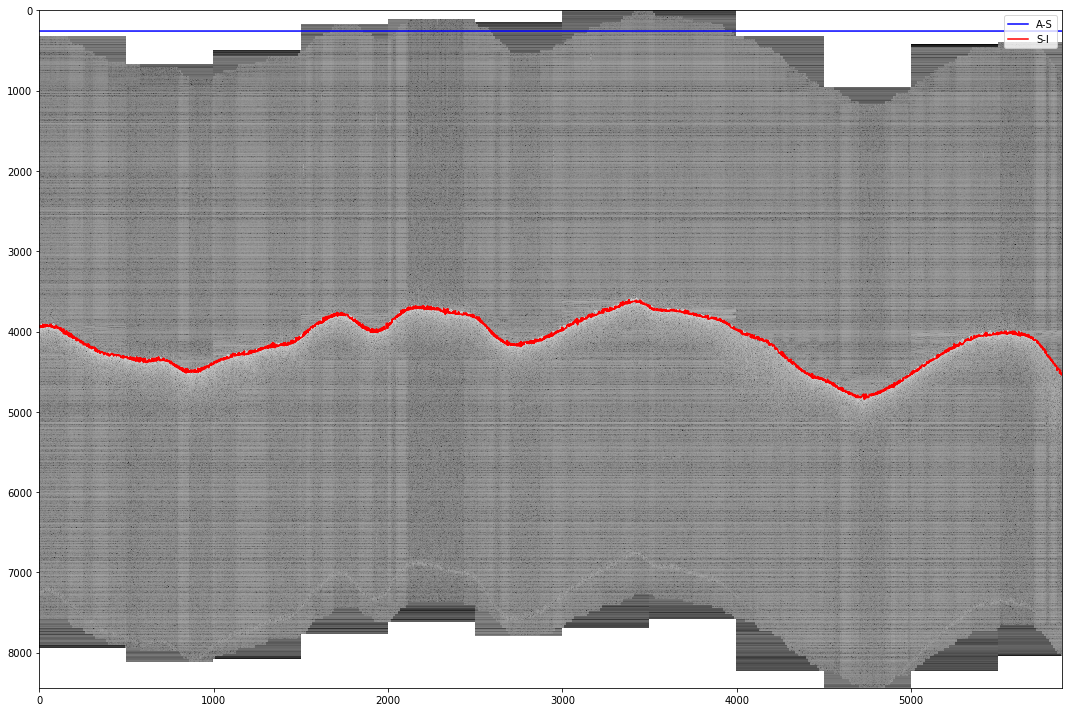

In [18]:
fig, ax = plt.subplots(figsize=(15,10))
with np.errstate(divide='ignore'):
    ax.imshow(20 * np.log10(radar_sub), interpolation='nearest', cmap="gist_gray")
ax.plot(l_as, color='b')
ax.plot(l_si, color='r')
#ax.set_ylim([1000, 500])
ax.legend(["A-S","S-I"],loc="upper right")

ax.set_aspect('auto')
fig.tight_layout();

#fig.savefig('20170310_01_088_Picks.pdf')

3910


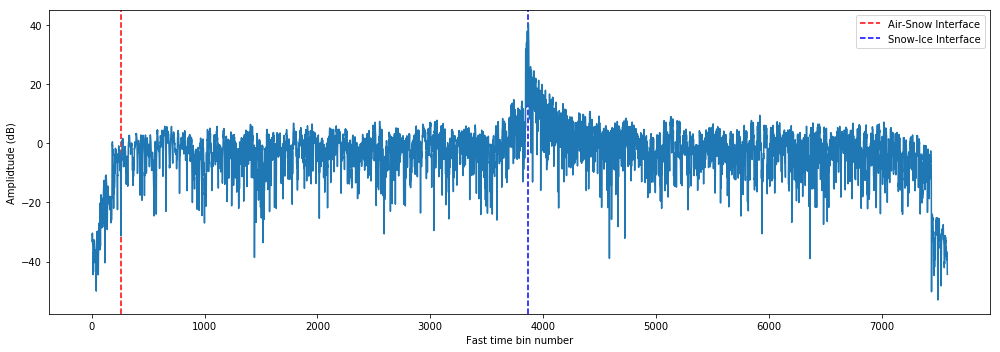

In [19]:
col_idx = np.random.randint(0, radar_sub.shape[1])
print(col_idx)
fig, ax = plt.subplots(figsize=(14,5))
#ax.plot(data_col)
with np.errstate(divide='ignore'):
    ax.plot(10*np.log10(radar_sub[:,col_idx]), label=None)
#ax.plot(radar_sub[:,col_idx], label=None)

# Air-Snow picked interface
ax.vlines(l_as[col_idx], 0, 1, label='Air-Snow Interface', linestyles='dashed', transform=ax.get_xaxis_transform(), color='r')
# Snow-Ice picked interface
ax.vlines(l_si[col_idx], 0, 1, label='Snow-Ice Interface', linestyles='dashed', transform=ax.get_xaxis_transform(), color='b')
ax.set_xlabel("Fast time bin number")
ax.set_ylabel("Amplidtude (dB)")
ax.legend(loc="upper right")
#ax.set_xlim([ymin, ymax])
fig.tight_layout();

#fig.savefig('20170310_01_088_AScope_Raw.pdf')